Pares encontrados: 8
000_seg_003.png: pixeles=[2428, 286, 7509, 1077], dispersion(LAB)=[0.0, 161.6995391845703, 14.16456413269043, 47.009517669677734]


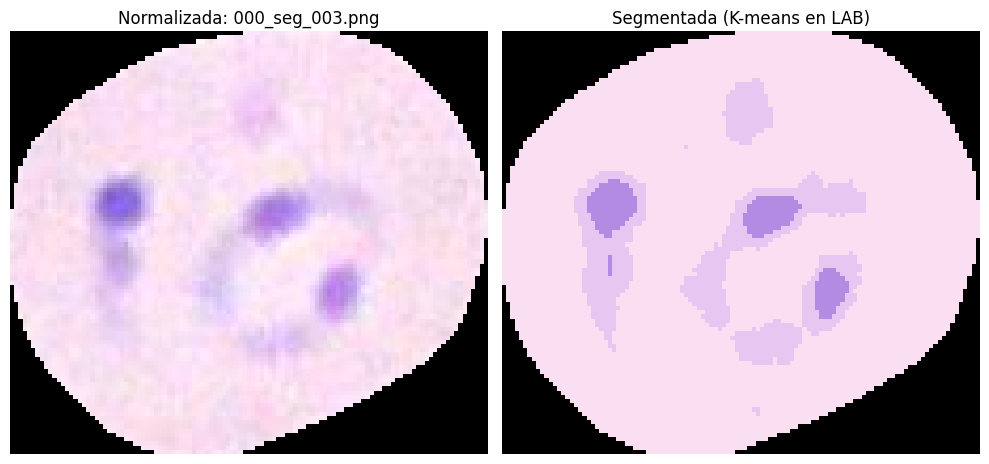

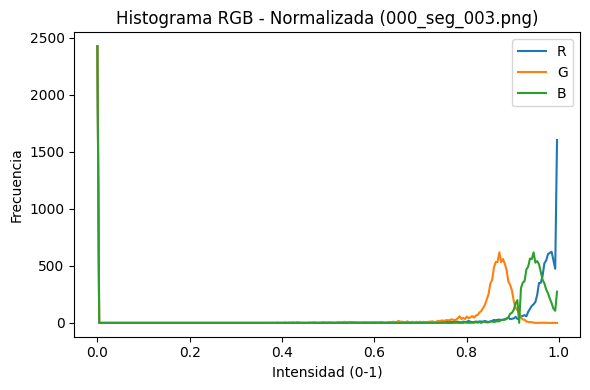

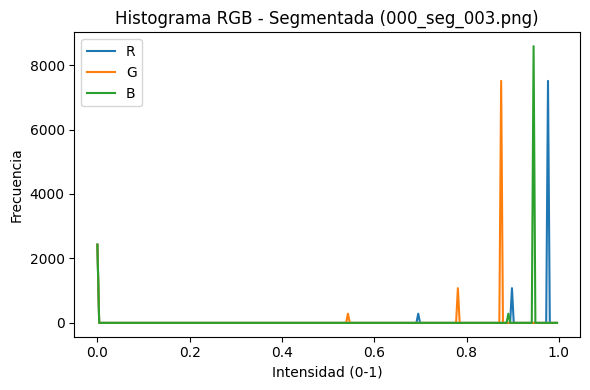

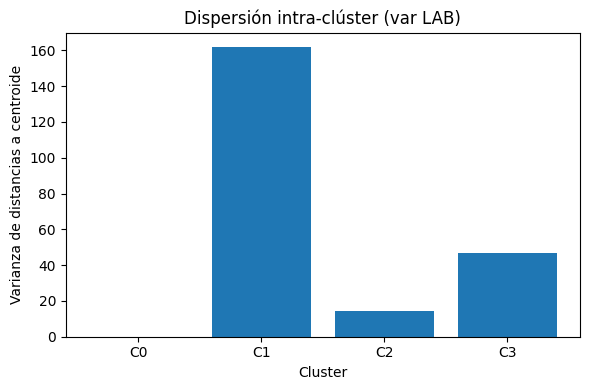

000_seg_004.png: pixeles=[2794, 659, 6824, 173], dispersion(LAB)=[0.0, 37.30342102050781, 13.281891822814941, 81.56277465820312]


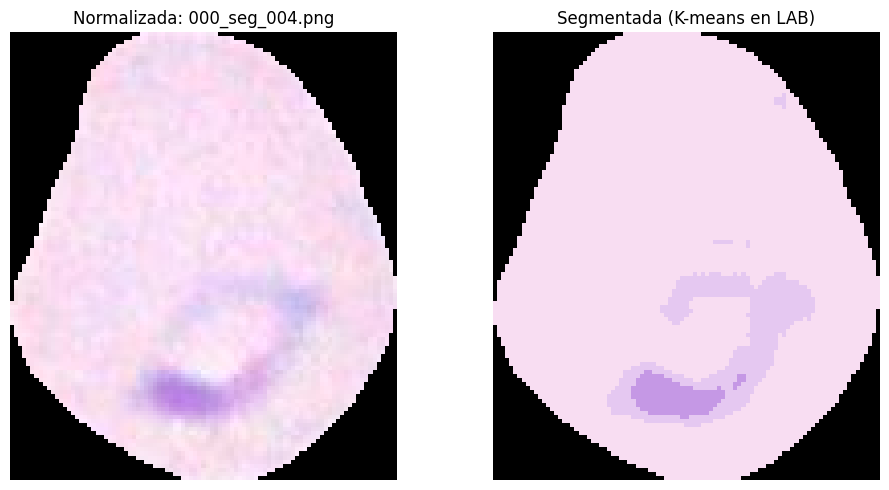

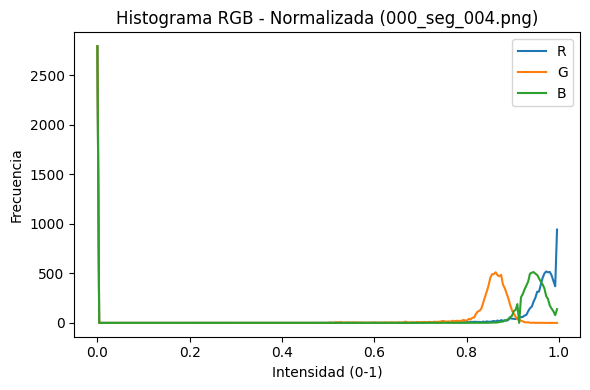

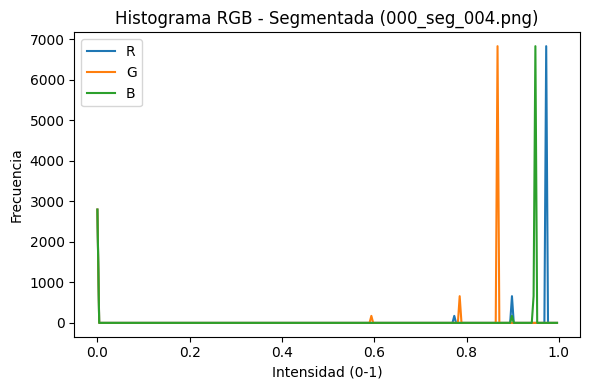

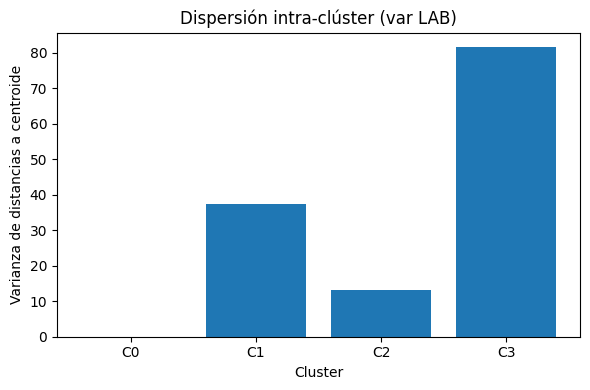

000_seg_000.png: pixeles=[877, 4862, 1864, 2000], dispersion(LAB)=[76.7040786743164, 25.053754806518555, 41.02365493774414, 0.0]


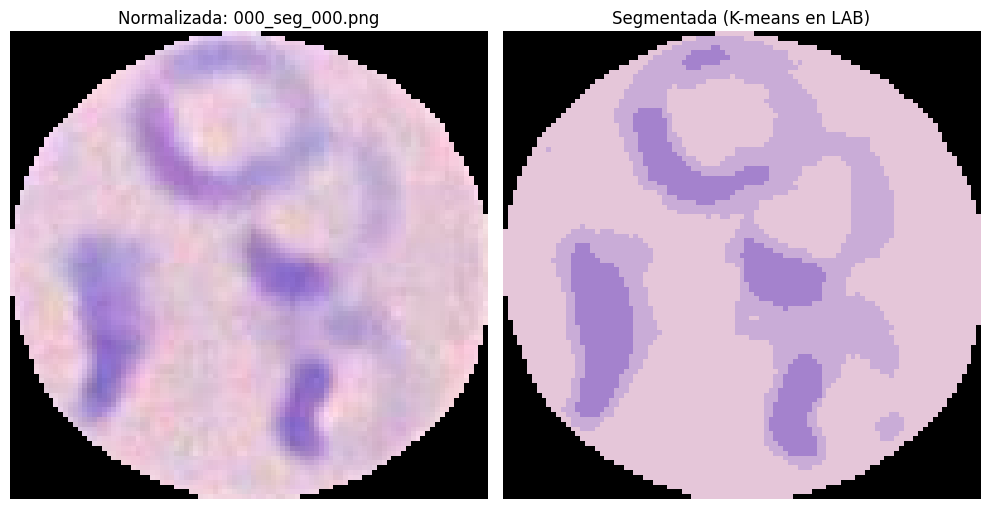

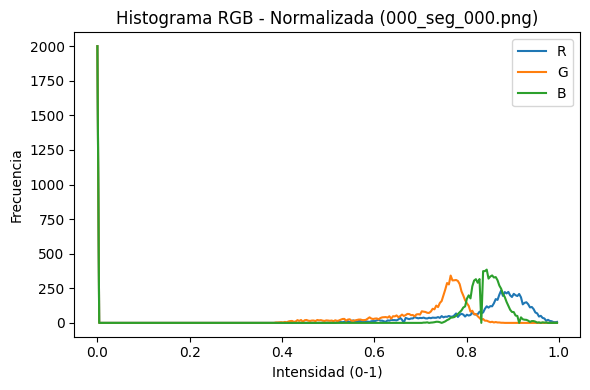

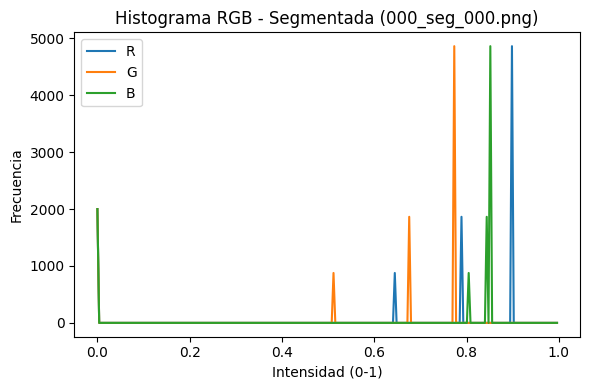

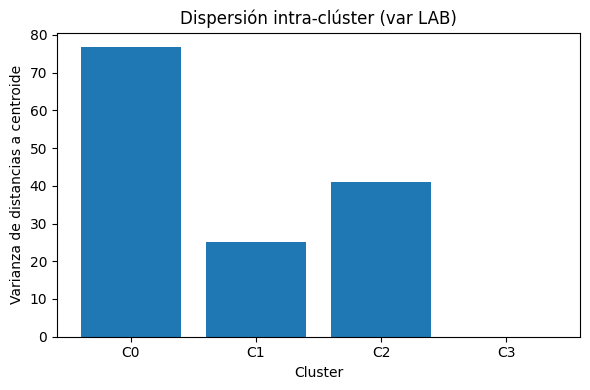

000_seg_001.png: pixeles=[1937, 453, 5197, 2381], dispersion(LAB)=[18.724550247192383, 76.8154525756836, 12.385964393615723, 0.0]


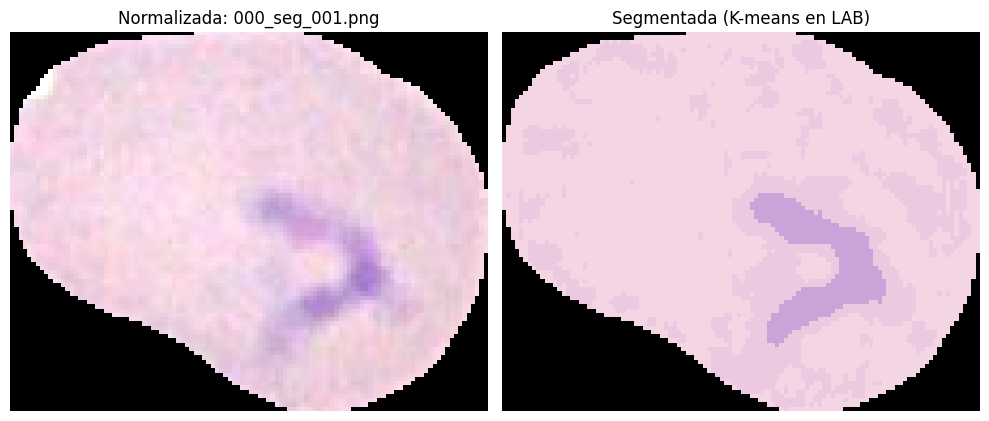

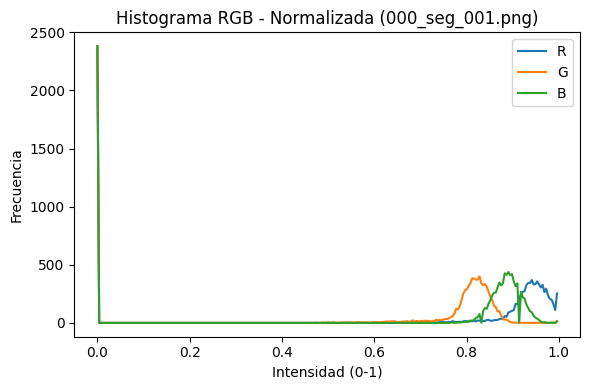

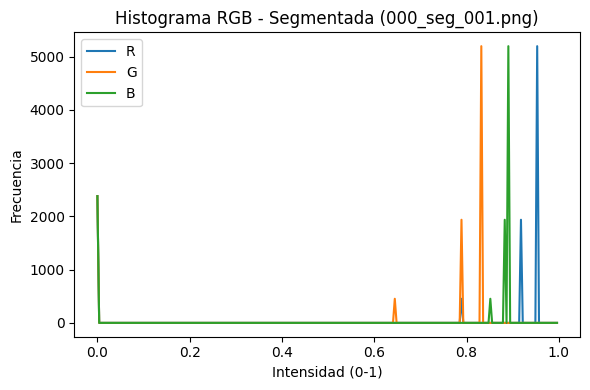

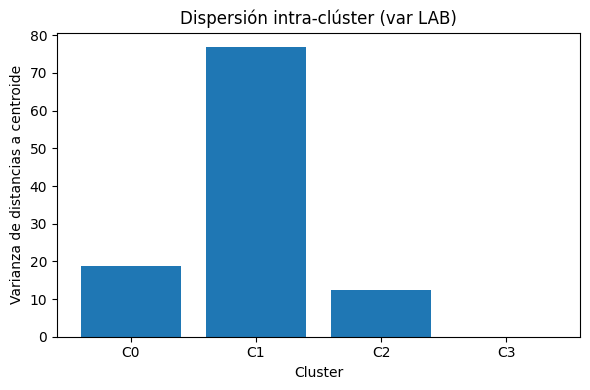

000_seg_007.png: pixeles=[2896, 6155, 788, 160], dispersion(LAB)=[0.0, 13.675806045532227, 58.711692810058594, 147.10556030273438]


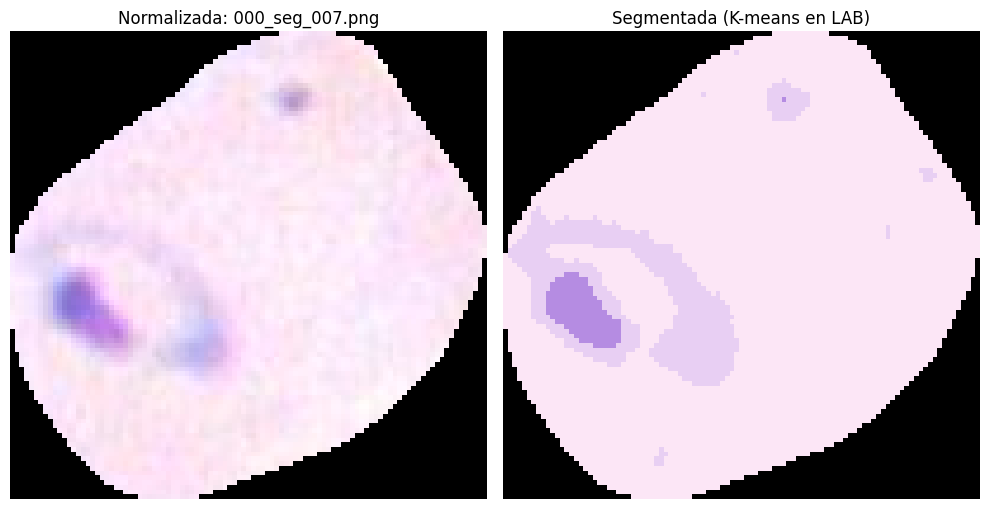

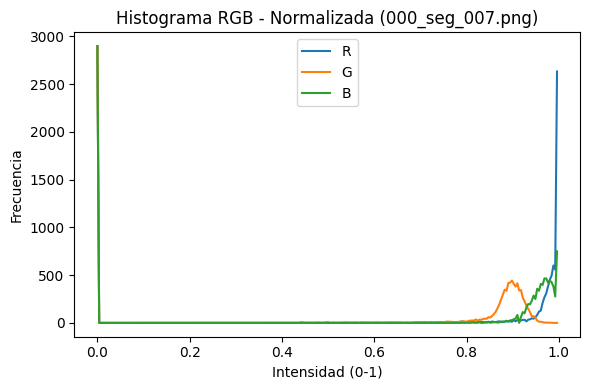

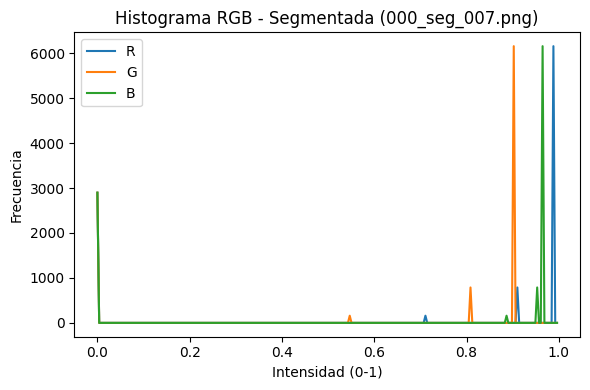

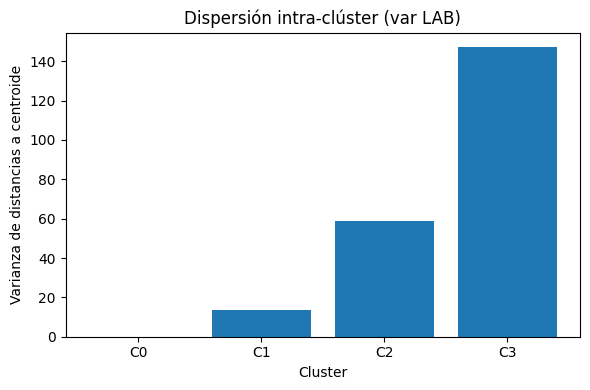

000_seg_006.png: pixeles=[7054, 2111, 330, 108], dispersion(LAB)=[12.801276206970215, 0.0, 74.60053253173828, 138.9257049560547]


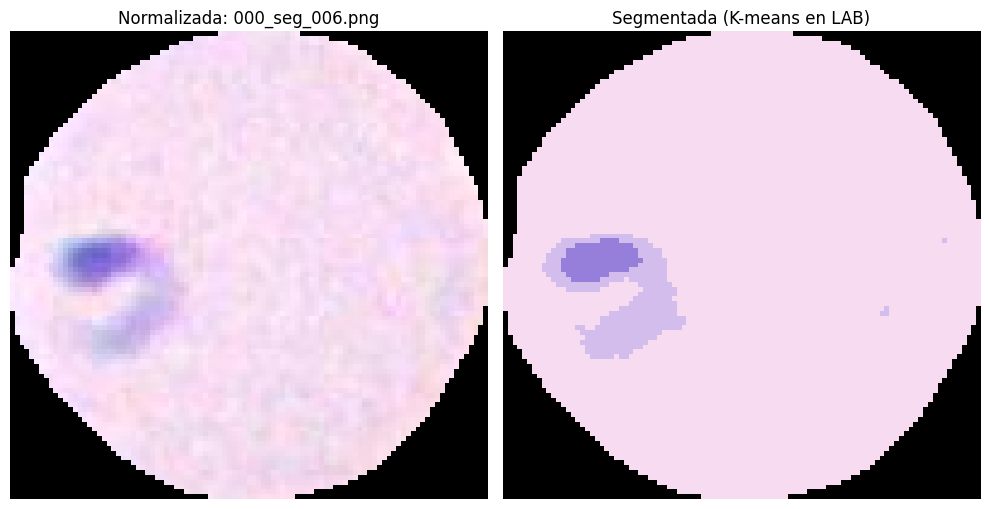

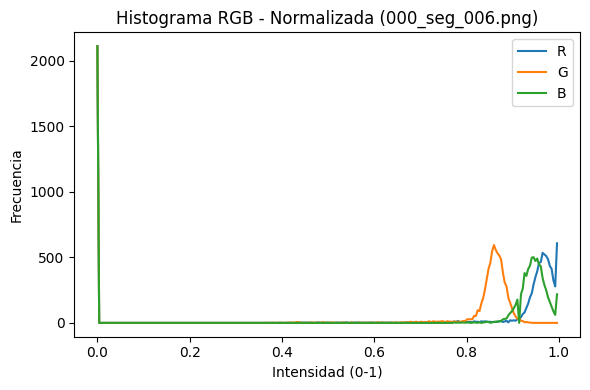

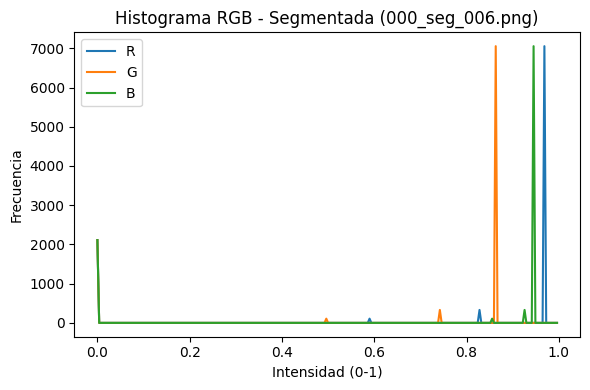

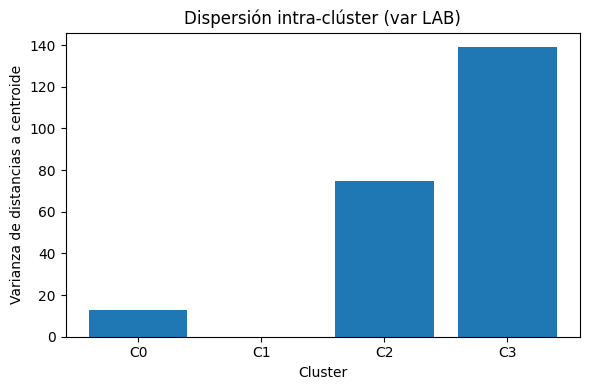

000_seg_005.png: pixeles=[3004, 5172, 127, 2605], dispersion(LAB)=[0.0, 12.88753890991211, 259.3728332519531, 10.767406463623047]


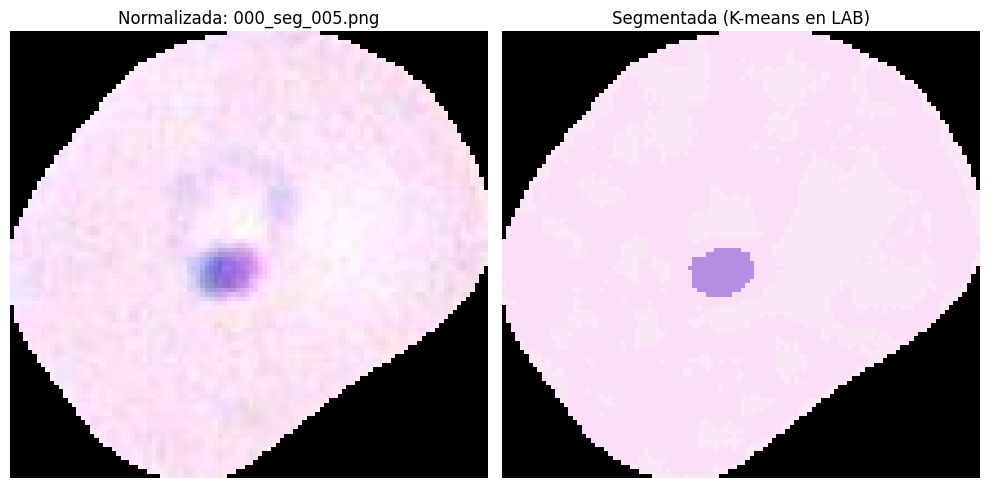

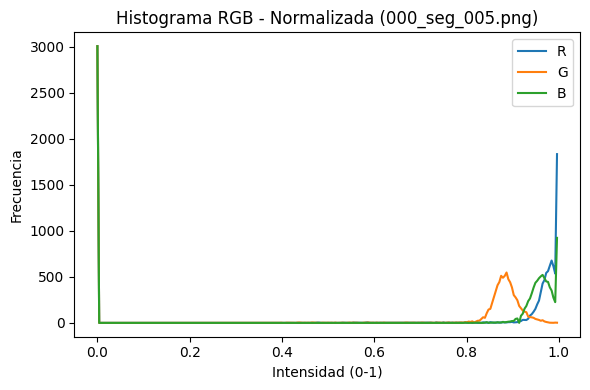

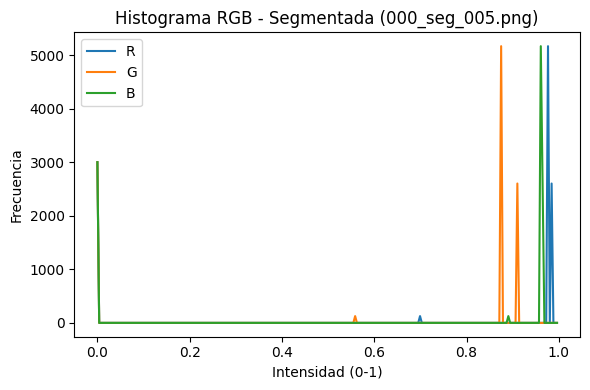

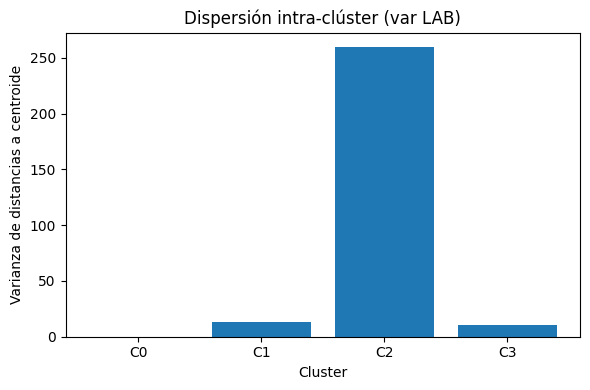

000_seg_002.png: pixeles=[6838, 2858, 146, 718], dispersion(LAB)=[11.962078094482422, 0.0, 124.291259765625, 35.90097427368164]


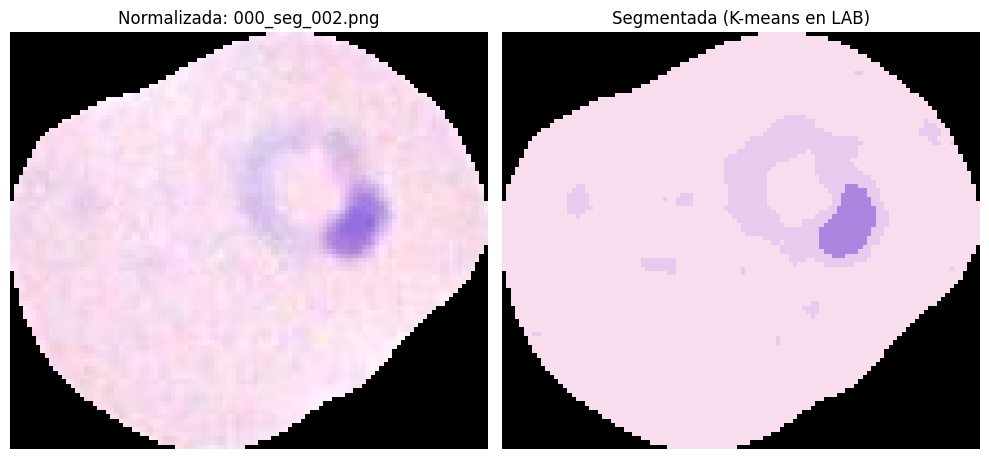

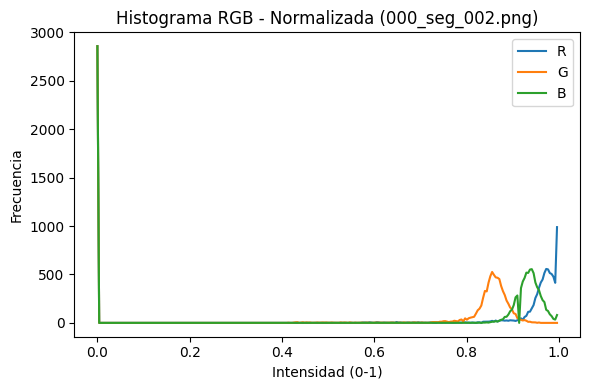

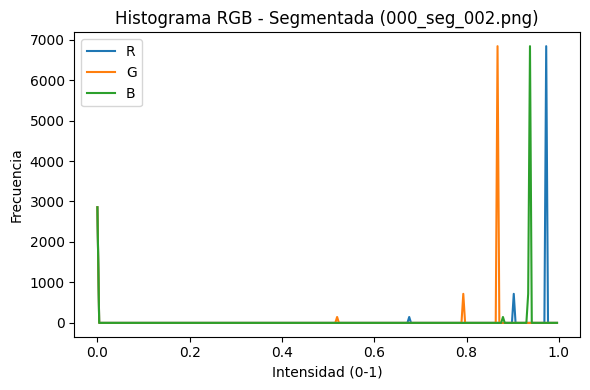

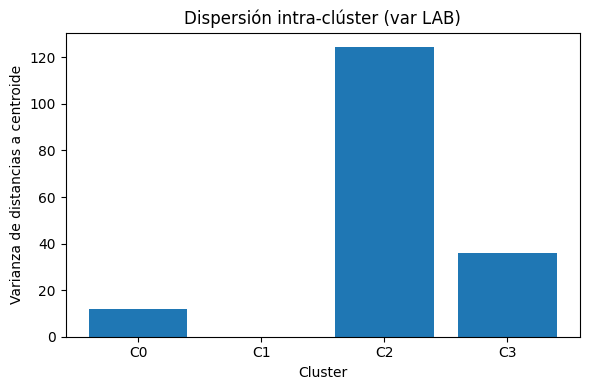


CSV con resumen guardado en: img/resumen_clusters.csv
Segmentaciones guardadas con sufijo _seg.png en la carpeta de entrada.


In [10]:
from pathlib import Path
import numpy as np
import cv2
from skimage import color as skcolor, img_as_ubyte
import matplotlib.pyplot as plt
import glob, os, csv

# =============== Utilidades ===============

def read_rgb_float01(path: str):
    """cv2.imread -> RGB float32 en [0,1]"""
    arr = cv2.imread(path, cv2.IMREAD_COLOR)
    if arr is None:
        raise FileNotFoundError(f"No se puede leer: {path}")
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return (arr.astype(np.float32) / 255.0)

def normalize_img(img: np.ndarray, rimg: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Normaliza por imagen de referencia, resultado en [0,1]."""
    norm = img / (rimg + eps)
    norm = np.nan_to_num(norm, nan=0.0, posinf=0.0, neginf=0.0)
    return np.clip(norm, 0.0, 1.0).astype(np.float32)

def kmeans_lab_segments(rgb_float: np.ndarray, K: int = 4, max_iter: int = 60, attempts: int = 20):
    """
    RGB[0,1] -> LAB, k-means en LAB.
    Devuelve: labels (N,), centers (K,3) en LAB, segmented_lab (H,W,3) en LAB, lab_image (H,W,3).
    """
    lab = skcolor.rgb2lab(rgb_float)               # float64
    h, w, _ = lab.shape
    samples = lab.reshape((-1, 3)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 1.0)
    compactness, labels, centers = cv2.kmeans(
        samples, K, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS
    )
    labels = labels.flatten()
    segmented_lab = centers[labels].reshape((h, w, 3))
    return labels, centers, segmented_lab, lab

def plot_rgb_histogram(img, title="Histograma RGB"):
    """
    Dibuja histogramas de los 3 canales de una imagen RGB [0,1].
    (Para distinguir canales, puedes activar los nombres en la leyenda.)
    """
    plt.figure(figsize=(6,4))
    for i, name in enumerate(("R","G","B")):
        hist, bins = np.histogram(img[:,:,i].ravel(), bins=256, range=(0,1))
        plt.plot(bins[:-1], hist, label=name)   # sin fijar colores explícitos
    plt.title(title)
    plt.xlabel("Intensidad (0-1)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.tight_layout()
    plt.show()

def cluster_dispersion(lab_image, labels, centers):
    """
    Varianza intra-clúster por centroide en LAB:
    sigma_k^2 = mean(||x_i - mu_k||^2) para i en cluster k.
    """
    X = lab_image.reshape((-1,3))
    dispersions = []
    for k in range(centers.shape[0]):
        pts = X[labels == k]
        if pts.shape[0] == 0:
            dispersions.append(np.nan)
        else:
            d2 = np.sum((pts - centers[k])**2, axis=1)  # dist^2
            dispersions.append(float(np.mean(d2)))
    return dispersions

# =============== Configuración ===============
root = "./img"        # cambia si es necesario
K = 4                 # número de clusters
save_dir = Path(root) # guarda segmentaciones junto a las imágenes
csv_path = Path(root) / "resumen_clusters.csv"

# =============== Buscar pares *_ref.png ===============
pairs = []
for ref_path in Path(root).rglob("*_ref.png"):
    img_path = Path(str(ref_path).replace("_ref.png", ".png"))
    if img_path.exists():
        pairs.append((img_path, ref_path))

print(f"Pares encontrados: {len(pairs)}")
if len(pairs) == 0:
    print("No se encontraron pares. Revisa rutas/formatos.")
    
# =============== CSV de salida (conteos y dispersión) ===============
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["imagen", "cluster", "pixeles", "dispersion_var(LAB)"])

    # =============== Proceso por imagen ===============
    for (img_path, ref_path) in pairs:
        # Lectura y normalización
        img  = read_rgb_float01(str(img_path))
        rimg = read_rgb_float01(str(ref_path))
        norm_img = normalize_img(img, rimg)

        # K-means en LAB
        labels, centers, seg_lab, lab_img = kmeans_lab_segments(norm_img, K=K)
        seg_rgb = skcolor.lab2rgb(seg_lab)  # para visualizar

        # Conteos y dispersión
        counts = np.bincount(labels, minlength=centers.shape[0]).astype(int).tolist()
        disp = cluster_dispersion(lab_img, labels, centers)

        # Guardar segmentación
        out_path = save_dir / f"{img_path.stem}_seg.png"
        cv2.imwrite(str(out_path), cv2.cvtColor(img_as_ubyte(seg_rgb), cv2.COLOR_RGB2BGR))

        # Log por consola
        print(f"{img_path.name}: pixeles={counts}, dispersion(LAB)={disp}")
        for k_idx in range(len(counts)):
            writer.writerow([img_path.name, k_idx, counts[k_idx], disp[k_idx]])

        # ---------- Mostrar imágenes ----------
        # Normalizada vs Segmentada
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(norm_img)
        plt.title(f"Normalizada: {img_path.name}")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(seg_rgb)
        plt.title("Segmentada (K-means en LAB)")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        # Histogramas RGB (antes y después)
        plot_rgb_histogram(norm_img, f"Histograma RGB - Normalizada ({img_path.name})")
        plot_rgb_histogram(seg_rgb,  f"Histograma RGB - Segmentada ({img_path.name})")

        # ---------- Gráfico de dispersión por clúster ----------
        plt.figure(figsize=(6,4))
        x = np.arange(len(disp))
        plt.bar(x, disp)
        plt.xticks(x, [f"C{k}" for k in range(len(disp))])
        plt.title("Dispersión intra-clúster (var LAB)")
        plt.xlabel("Cluster")
        plt.ylabel("Varianza de distancias a centroide")
        plt.tight_layout()
        plt.show()

print(f"\nCSV con resumen guardado en: {csv_path}")
print("Segmentaciones guardadas con sufijo _seg.png en la carpeta de entrada.")
